In [32]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean, get_MOI, get_SHM_invariance, get_pendulum_invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_SHM_data, get_pendulum_data, get_grid_of_points_1D, evaluate_model_future, evaluate_model_grid, SHM_dynamics, pendulum_dynamics
from parameterised_invariance_kernels import get_polynomial_invariance
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [33]:
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time =  1

max_x = 150  
n_train = 3 
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_x/5, max_x/5, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_pendulum_data(time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[ 55.20189407  -6.33850643 -91.1270633 ]
[-21.86125985  -2.61757021 -22.38320763]


In [35]:
jitter = 5e-6
invar_density = 20
moi = get_GPR_model(get_MOI(), mean, data, 500)
print("moi: %s"%moi.log_marginal_likelihood().numpy())
kernel = get_pendulum_invariance(3, invar_density, jitter) #switch
known = get_GPR_model(kernel, mean, data, 500)
print("known: %s"%known.log_marginal_likelihood().numpy())
latex = ""
try:
    for poly_f_d in [1, 2, 3, 4, 5]:
        for poly_g_d in [1, 2, 3, 4, 5]:
            kernel = get_polynomial_invariance(3, invar_density, jitter, poly_f_d, poly_g_d) #switch
            m = get_GPR_model(kernel, mean, data, 500)
            print("(%s, %s)----------------------"%(poly_f_d, poly_g_d))
            print(kernel.f_poly.numpy())
            print(kernel.g_poly.numpy())
            print(format(m.log_marginal_likelihood().numpy(),".2f"))
            latex+=format(m.log_marginal_likelihood().numpy(),".2f")
            latex+="&"
except tf.errors.InvalidArgumentError:
    print("jitter too small")

moi: 229.1479184490782
known: 262.467468766
(1, 1)----------------------
[[-4.91149565e-10]]
[[-5.89833071e-10]]
228.14
(1, 2)----------------------
[[-0.0001896]]
[[8.59454730e-11]
 [2.11834564e-04]]
229.21
(1, 3)----------------------
[[-0.00028102]]
[[3.22974980e-11]
 [3.11900034e-04]
 [3.21462513e-05]]
219.89
(1, 4)----------------------
[[-0.00071437]]
[[-4.84895483e-08]
 [ 1.04556027e-03]
 [ 2.02122641e-04]
 [ 1.87388219e-04]]
227.58
(1, 5)----------------------
[[-0.00071446]]
[[ 1.18152155e-11]
 [ 1.69673162e-03]
 [-1.08532609e-04]
 [-6.72034411e-04]
 [-9.36510500e-05]]
216.83
(2, 1)----------------------
[[-9.85367331e-07]
 [ 1.14122045e-11]]
[[0.0023649]]
-49.79
(2, 2)----------------------
[[ 1.08986112e-05]
 [-2.95719005e-12]]
[[-2.29244828e-03]
 [ 1.78611792e-05]]
-49.79
(2, 3)----------------------
[[-1.02796325e-03]
 [-2.84657671e-07]]
[[ 3.30471574e-05]
 [-5.19584376e-13]
 [ 4.20733338e-03]]
-49.49
(2, 4)----------------------
[[ 1.]
 [-1.]]
[[1.]
 [1.]
 [1.]
 [1.]]
-34

In [8]:
latex

'140.61&140.83&139.45&140.99&-34.20&156.16&150.16&-58.81&136.18&-34.33&149.97&-34.29&140.84&nan&-34.17&-34.12&'

In [16]:
lml_moi = []
lml_inv = []
lml_inv_p = []
eva_future_moi = []
eva_future_inv = []
eva_future_inv_p = []
eva_grid_moi = []
eva_grid_inv = []
eva_grid_inv_p = []
for i in range(1):
    test_starting_position = (np.random.uniform(-max_x,max_x))
    test_starting_velocity = (np.random.uniform(-max_x/5, max_x/5))

    print(test_starting_position)
    print(test_starting_velocity)

    evaluate_moi = evaluate_model_future(moi, test_starting_position, test_starting_velocity, SHM_dynamics, testing_time, time_step)
    lml_moi.append(moi.log_marginal_likelihood().numpy())
    eva_future_moi.append(evaluate_moi[0])
    eva_grid_moi.append(evaluate_model_grid(moi, (3), 40, SHM_dynamics))

    evaluate_invariance = evaluate_model_future(known, test_starting_position, test_starting_velocity, SHM_dynamics, testing_time, time_step)
    lml_inv.append(known.log_marginal_likelihood().numpy())
    eva_future_inv.append(evaluate_invariance[0])
    eva_grid_inv.append(evaluate_model_grid(known, (3), 40, SHM_dynamics))

    evaluate_invariance_p = evaluate_model_future(m, test_starting_position, test_starting_velocity, SHM_dynamics, testing_time, time_step)
    lml_inv_p.append(m.log_marginal_likelihood().numpy())
    eva_future_inv_p.append(evaluate_invariance_p[0])
    eva_grid_inv_p.append(evaluate_model_grid(m, (3), 40, SHM_dynamics))

-0.21693996312783081
0.4189533173771779


In [12]:

print("Baseline RBF & " + format(np.mean(lml_moi),".2f")+" & "+format(np.mean(eva_future_moi),".4f")+" & "+format(np.mean(eva_grid_moi),".4f")+' \\\\')
print("Invariance Kernel & "+ format(np.mean(lml_inv),".2f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format(np.mean(eva_grid_inv),".4f")+ ' \\\\')
print("Parameterised Kernel & "+ format(np.mean(lml_inv_p),".2f")+" & "+format(np.mean(eva_future_inv_p),".4f")+" & "+format(np.mean(eva_grid_inv_p),".4f")+ ' \\\\')

Baseline RBF & 141.16 & 0.1581 & 0.8303 \\
Invariance Kernel & 168.44 & 0.0052 & 0.0417 \\
Parameterised Kernel & 155.91 & 0.0303 & 0.3750 \\


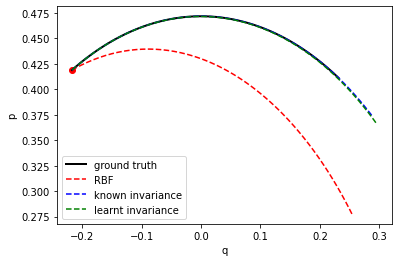

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="ground truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
plt.savefig("figures/parameterised_shm_predicted_trajectory.pdf")

In [20]:
m.kernel.f_poly.numpy()

array([[-5.68691139e-09],
       [-1.78635194e-02]])

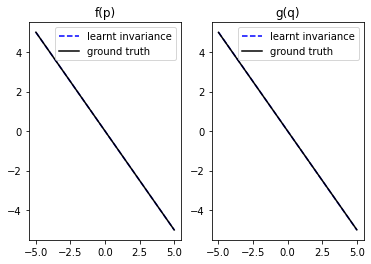

In [28]:
from numpy.polynomial import polynomial
x = np.linspace(-5,5,100)
multiplier = -m.kernel.f_poly.numpy()[1]
f = polynomial.Polynomial(np.squeeze(kernel.f_poly.numpy()))
g = polynomial.Polynomial(np.squeeze(kernel.g_poly.numpy()))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, f(x)/multiplier, "--", color="blue", label='learnt invariance')
ax1.plot(x, -x, label='ground truth', color="black")
ax1.set_title("f(p)")
ax1.legend()
ax2.set_title("g(q)")
ax2.plot(x, g(x)/multiplier, "--", color="blue",label='learnt invariance')
ax2.plot(x, -x, color="black", label='ground truth')
ax2.legend()
plt.savefig("figures/parameterised_shm_learnt_polynomial.pdf")
